# Set up

## Install dependencies

In [1]:
!pip3 install opencv-python-headless

!pip3 install 'git+https://github.com/facebookresearch/detectron2.git'

!pip3 install ultralytics
!pip3 install transformers

!git clone https://github.com/facebookresearch/Detic.git --recurse-submodules
!pip3 install -r "/content/Detic/requirements.txt"

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-chq7tphs
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-chq7tphs
  Resolved https://github.com/facebookresearch/detectron2.git to commit c69939aa85460e8135f40bce908a6cddaa73065f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.1 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp310

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.0/899.0 kB 15.7 MB/s eta 0:00:00
Cloning into 'Detic'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 210 (delta 59), reused 56 (delta 56), pack-reused 99 (from 1)
Receiving objects: 100% (210/210), 3.58 MiB | 16.97 MiB/s, done.
Resolving deltas: 100% (85/85), done.
Submodule 'third_party/CenterNet2' (https://github.com/xingyizhou/CenterNet2.git) registered for path 'third_party/CenterNet2'
Submodule 'third_party/Deformable-DETR' (https://github.com/fundamentalvision/Deformable-DETR.git) registered for path 'third_party/Deformable-DETR'
Cloning into '/content/Detic/third_party/CenterNet2'...
remote: Enumerating objects: 13925, done.        
remote: Counting objects: 100% (949/949), done.        
remote: Compressing objects: 100% (101/101), done.        
remote: Total 13925 (delta 887), reused 854 (delta 846), pack-reused 12976 (from 1

## Imports and helper functions


In [2]:
import cv2
import gdown
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch


from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog


In [3]:
original_dir = os.getcwd()

sys.path.insert(0, original_dir + "/Detic/third_party/CenterNet2/")
sys.path.insert(0, original_dir + "/Detic/")

os.chdir(os.path.join(original_dir, "Detic"))

sys.path.insert(0, 'third_party/CenterNet2/')
from centernet.config import add_centernet_config
from detic.config import add_detic_config
from detic.modeling.utils import reset_cls_test
from detic.modeling.text.text_encoder import build_text_encoder

os.chdir(original_dir)


/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [4]:
class DeticDetector:
    def __init__(self, vocabulary=['cardboard box'], device='cpu'):
        os.chdir(os.path.join(original_dir, "Detic"))
        self.cfg = self._setup_cfg(device)
        self.predictor = DefaultPredictor(self.cfg)
        self.metadata = self._setup_metadata(vocabulary)
        self._setup_classifier(vocabulary)
        self.vocabulary = vocabulary
        os.chdir(original_dir)


    def _setup_cfg(self, device):
        cfg = get_cfg()
        add_centernet_config(cfg)
        add_detic_config(cfg)
        cfg.merge_from_file("configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml")
        cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth'
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
        cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = 'rand'
        cfg.MODEL.ROI_HEADS.ONE_CLASS_PER_PROPOSAL = True
        cfg.MODEL.DEVICE = device
        return cfg

    def _setup_metadata(self, vocabulary):
        metadata = MetadataCatalog.get("__unused")
        metadata.thing_classes = vocabulary
        return metadata

    def _setup_classifier(self, vocabulary):
        classifier = self._get_clip_embeddings(vocabulary)
        num_classes = len(vocabulary)
        reset_cls_test(self.predictor.model, classifier, num_classes)
        output_score_threshold = 0.3
        for cascade_stages in range(len(self.predictor.model.roi_heads.box_predictor)):
            self.predictor.model.roi_heads.box_predictor[cascade_stages].test_score_thresh = output_score_threshold

    def _get_clip_embeddings(self, vocabulary, prompt='a '):
        text_encoder = build_text_encoder(pretrain=True)
        text_encoder.eval()
        texts = [prompt + x for x in vocabulary]
        emb = text_encoder(texts).detach().permute(1, 0).contiguous().cpu()
        return emb

    def detect(self, image_path):
        image = cv2.imread(image_path)
        outputs = self.predictor(image)

        instances = outputs["instances"].to("cpu")
        boxes = instances.pred_boxes.tensor.numpy()
        scores = instances.scores.numpy()
        class_ids = instances.pred_classes.numpy()

        # Convert boxes to COCO format (x_center, y_center, width, height)
        image_height, image_width = image.shape[:2]
        coco_boxes = []
        for box in boxes:
            x1, y1, x2, y2 = box
            x_center = (x1 + x2) / (2 * image_width)
            y_center = (y1 + y2) / (2 * image_height)
            width = (x2 - x1) / image_width
            height = (y2 - y1) / image_height
            coco_boxes.append((x_center, y_center, width, height))

        # Convert class IDs to label strings
        labels = [self.vocabulary[class_id] for class_id in class_ids]

        return coco_boxes, labels, scores.tolist()

    def visualize(self, image_path) -> np.ndarray:
        image = cv2.imread(image_path)
        outputs = self.predictor(image)
        v = Visualizer(image[:, :, ::-1], self.metadata)
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        return out.get_image()[:, :, ::-1]


## Set the data and the labels to detect

In [29]:
# !git clone "https://github.com/Kickstartai-product/kai-tutorials/"
# gh_path = os.path.join(os.getcwd(), "kai-tutorials", "tutorials", "efficient_image_annotation_with_Detic")

# # TODO: remove the hard-coded path

# !cp "/content/kai-tutorials/tutorials/efficient_image_annotation_with_Detic/dataset_utils.py" "."
# !cp "/content/kai-tutorials/tutorials/efficient_image_annotation_with_Detic/detic_detector.py" "."


In [33]:
# file_id = "1nH7gOuEuOKpZccAVfxO29J39pfTSk47V"
# download_url = f'https://drive.google.com/uc?id={file_id}'
# output_file = 'data.zip'
# gdown.download(download_url, output_file, quiet=False)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Meke sure to upload your image to Drive.

In [6]:
image_file = "/content/drive/MyDrive/helmets.png"
labels_to_detect = ["helmet"]

# Run Detic

In [7]:
 # initialize DETIC
device = "cuda" if torch.cuda.is_available() else "cpu"

detector = DeticDetector(vocabulary=labels_to_detect, device=device)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth: 702MB [00:04, 171MB/s]                           
/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary 

Loading pretrained CLIP


In [8]:
# Process image
print(f"analysing {image_file}...")
if not image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
    raise Exception("Only PNG, JPG, and JPEG images are supported")

# Detect objects using DETIC
detected_boxes, detected_labels, probabilities = detector.detect(image_file)

analysing /content/drive/MyDrive/helmets.png...


In [9]:
print("Detected boxes:")
print(detected_boxes)

print("\nDetected labels:")
print(detected_labels)

print("\nProbabilities:")
print(probabilities)

Detected boxes:
[(0.4184708463931512, 0.5518239155573105, 0.15405620643478668, 0.23227826610799301), (0.22807262671921782, 0.45074168181161156, 0.17082446435254492, 0.1735430555653486)]

Detected labels:
['helmet', 'helmet']

Probabilities:
[0.7159080505371094, 0.69731605052948]


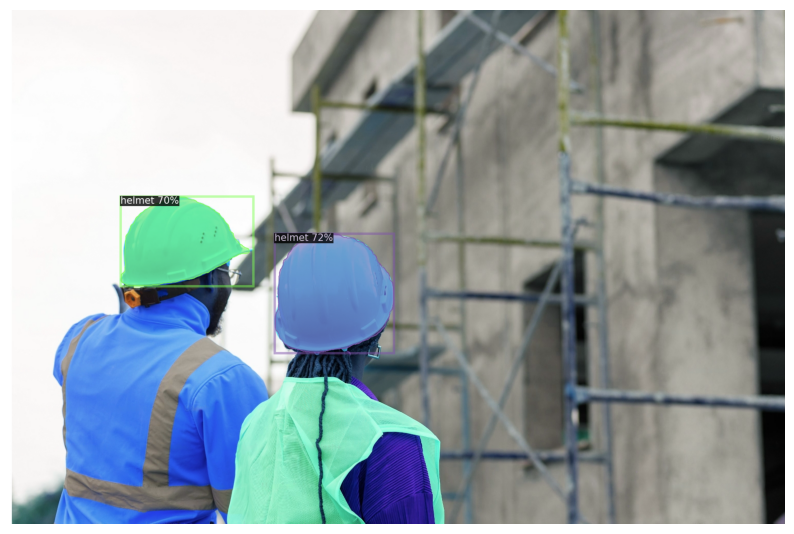

In [11]:
 # Generate DETIC visualization
results = detector.visualize(image_file)

plt.figure(figsize=(10, 10))
plt.imshow(results)
plt.axis("off")
plt.show()